# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [0]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd

filtered_data= pd.read_csv('/content/drive/My Drive/data.csv')

#give reviews with score>1 positive rating(1) and reviews with negative rating(0)
def partition(x):
  if x<3:
    return 0
  return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 11)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
filtered_data=filtered_data.drop( 'Unnamed: 0',axis=1) 

# **Text Data Cleaning: Deduplication**

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
filtered_data[(filtered_data['Time']== 1199577600) & (filtered_data['ProfileName'] == "Geetha Krishnan")]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
67901,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
72060,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
127440,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
127478,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
142859,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...




As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#sort the data in ascending order with respect to the product id
sorted_data= filtered_data.sort_values('ProductId',axis =0, ascending= True , inplace= False, kind= 'quicksort')

In [0]:
#deleting duplicate data
final = sorted_data.drop_duplicates(subset ={'UserId','Time', 'Text','ProfileName'}, keep= 'first', inplace= False)

In [0]:
final.shape

(364173, 10)

In [0]:
#check percentage of data retained
(final['Id'].size*1.0 / sorted_data['Id'].size*1.0) *100

69.25890143662969

It is also observed that for some entries the helpfulness numerator is greater than helpfulness denominator which is completely absurd.


In [0]:
final[final['HelpfulnessNumerator'] > final['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final =final[ final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]

In [0]:
print(final.shape)

(364171, 10)


# Pre processing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags. 
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric.
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters).
Convert the word to lowercase.
Remove Stopwords

After which we collect the words used to describe positive and negative reviews

In [0]:
# print some random reviews
rev0 = final['Text'].values[0]
print(rev0)
print("="*50)
rev1 = final['Text'].values[100]
print(rev1)
print("="*50)
rev2 = final['Text'].values[1000]
print(rev2)
print("="*50)



this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise

In [0]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
print(rev0)
rev0 = decontracted(rev0)
print(rev0)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
this witty little book makes my son laugh at loud. i recite it in the car as we are driving along and he always can sing the refrain. he is learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
   
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [01:43<00:00, 3535.02it/s]


In [0]:
preprocessed_reviews[100]


'pros dog anything treat not smell bad many treats easy break smaller pieces nothing artificial easy digestion cons costly dog treats overall great product expensive dog anything treat several phobias including getting car walking doorways ignores fears get treat'

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_1, y_train, y_1 = train_test_split(preprocessed_reviews, final['Score'], test_size=0.30, random_state=0)
X_cv, X_test,y_cv,y_test= train_test_split(X_1,y_1 ,test_size=0.50, random_state=0)
print("size of training data", len(X_train))
print("size of cross validation data", len(X_cv))
print("size of test data", len(X_test))
del(preprocessed_reviews)
del(final) 

size of training data 254919
size of cross validation data 54626
size of test data 54626


# Featurization

## Bag of Words

In [0]:
##vectorization of training data
count_vec= CountVectorizer(min_df=10)
count_vec.fit(X_train)
print("Some features" , count_vec.get_feature_names()[56:70])
print('.'*50)
bow_train = count_vec.transform(X_train)
print(type(bow_train))
print("the shape of out text BOW vectorizer of training set",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
##vectorization of cross validation data and training set

bow_cv= count_vec.transform(X_cv)
print("the shape of out text BOW vectorizer of cross validation ",bow_cv.get_shape())
bow_test=count_vec.transform(X_test)
print("the shape of out text BOW vectorizer of test set ",bow_test.get_shape())

Some features ['accented', 'accents', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accessories', 'accessory', 'accident']
..................................................
<class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer of training set (254919, 19388)
the number of unique words  19388
the shape of out text BOW vectorizer of cross validation  (54626, 19388)
the shape of out text BOW vectorizer of test set  (54626, 19388)


In [0]:
# noramalizing the data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train = preprocessing.normalize(bow_train)
bow_cv = preprocessing.normalize(bow_cv)
bow_test= preprocessing.normalize(bow_test)

## Tf-Idf

In [0]:
tf_idf_vec= TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vec.fit(X_train)
print("Some unique features", tf_idf_vec.get_feature_names()[:10])

tfidf_train= tf_idf_vec.transform(X_train)
print("the type of count vectorizer ",type(tfidf_train))
print("the shape of out text TFIDF vectorizer train ",tfidf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_train.get_shape()[1])


tfidf_cv= tf_idf_vec.transform(X_cv)
print("the shape of out text TFIDF vectorizer cv",tfidf_cv.get_shape())
tfidf_test= tf_idf_vec.transform(X_test)
print("the shape of out text TFIDF vectorizer test",tfidf_test.get_shape())


Some unique features ['aa', 'aaa', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey', 'abby', 'abc']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer train  (254919, 144520)
the number of unique words including both unigrams and bigrams  144520
the shape of out text TFIDF vectorizer cv (54626, 144520)
the shape of out text TFIDF vectorizer test (54626, 144520)


In [0]:
 # noramalizing the data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train = preprocessing.normalize(tfidf_train)
tfidf_cv = preprocessing.normalize(tfidf_cv)
tfidf_test= preprocessing.normalize(tfidf_test)

#Naive bayes with simple cross validation 

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB

## Training the model 

In [0]:
def NB(X_train, X_cv,y_train, y_cv):
 best_alpha= 0
 max_roc_auc= -1
 alphas=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
 roc_auc_train=[]
 roc_auc_cv=[]
 probs=[] # probability values for best alpha
 for i in alphas[-19:]:
    clf= MultinomialNB(alpha=i)
    clf.fit(X_train,y_train)
    pred_train= clf.predict_proba(X_train)
    pred_cv= clf.predict_proba(X_cv)
    auc_score_train= roc_auc_score(y_train,pred_train[:,1])
    auc_score_cv= roc_auc_score(y_cv,pred_cv[:,1])
    print(i,"------>",auc_score_cv)
    roc_auc_train.append( auc_score_train)
    roc_auc_cv.append( auc_score_cv)
    if(auc_score_cv>max_roc_auc):
      max_roc_auc= auc_score_cv
      best_alpha= i
      probs=pred_cv
 print(best_alpha, " is the best value of alpha with an roc_auc score of ", max_roc_auc)
 sns.set_style("darkgrid")
 plt.xscale("log")
 plt.plot(alphas,roc_auc_train,'r-', label="training data")
 plt.plot(alphas,roc_auc_cv,'g-', label="Cv data")
 plt.legend(loc='upper right')
 plt.title(r'Auc Score v/s $alpha$')
 plt.xlabel(r"$alpha$", fontsize= 12)
 plt.xlabel("auc value", fontsize= 12)
 plt.show()
 #for roc curve
 fpr, tpr, thresholds = metrics.roc_curve(y_cv,probs[:,1])
 plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
 plt.plot(fpr,tpr,marker='.')
 plt.title(r"ROC curve on cv data with best $aplha$ ")
 plt.xlabel("false positive rate", fontsize=12)
 plt.ylabel("True positive rate", fontsize=12)
 plt.show()
 return best_alpha

##Testing the model

In [0]:
import scikitplot.metrics as skplt
def testing(X_train, X_test,y_train, y_test,optimal_alpha):
  clf= MultinomialNB(alpha= optimal_alpha)
  clf.fit(X_train,y_train)
  probs= clf.predict_proba(X_test)
  probs= probs[:,1] #keeping probabilities of positive classes only
  print("AUC score on test data", roc_auc_score(y_test,probs))
  #plotting the roc curve
  fpr, tpr, thresholds= metrics.roc_curve(y_test, probs)
  plt.plot([0,1],[0,1],linestyle='--')# for a random(dumb) model
  plt.plot(fpr,tpr,marker='.')
  plt.title(r"ROC curve on test data with best $aplha$ ")
  plt.xlabel("false positive rate", fontsize=12)
  plt.ylabel("True positive rate", fontsize=12)
  plt.show()
  prediction = clf.predict(X_test)
  skplt.plot_confusion_matrix(y_test,prediction)
  print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
  print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
  print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
  print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))


##Important features

In [0]:
def impFeatures(model,clf):
  neg= clf.feature_log_prob_[0,:].argsort()
  pos= clf.feature_log_prob_[1,:].argsort()
  top_pos_words= np.take(model.get_feature_names(),pos)
  top_neg_words= np.take(model.get_feature_names(),neg)
  imp_df= pd.DataFrame(columns={'Positive word'})#'Positive importance','Negative word','Negative importance'})
  imp_df["Positive word"]= top_pos_words[::-1]
  imp_df["Positive importance"]= np.take(clf.feature_log_prob_[1,:],pos)[::-1]
  imp_df["Negative word"]= top_neg_words[::-1]
  imp_df["Negative importance"]= np.take(clf.feature_log_prob_[0,:],neg)[::-1]
  return imp_df

##Implementation  on Bag of Words

10000 ------> 0.554511306338763
5000 ------> 0.5843486621875942
1000 ------> 0.6502324654949865
500 ------> 0.6752421662312907
100 ------> 0.7465587752776
50 ------> 0.7933178663750158
10 ------> 0.9045776169903553
5 ------> 0.9258737830401182
1 ------> 0.9413325655208777
0.5 ------> 0.9435453877836097
0.1 ------> 0.9449890887506076
0.05 ------> 0.9448659594376156
0.01 ------> 0.9440347476797173
0.005 ------> 0.9435486434916092
0.001 ------> 0.9422264402008287
0.0005 ------> 0.9416036391481896
0.0001 ------> 0.940094589489178
5e-05 ------> 0.939429966080642
1e-05 ------> 0.9378826322209028
0.1  is the best value of alpha with an roc_auc score of  0.9449890887506076


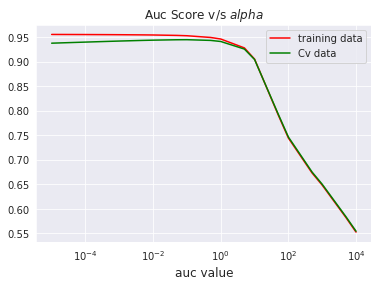

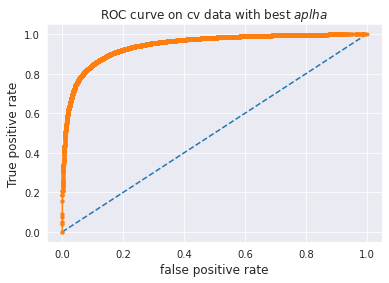

In [153]:
#training the model
optimal_alpha= NB(bow_train,bow_cv,y_train,y_cv)

AUC score on test data 0.9448606764831625


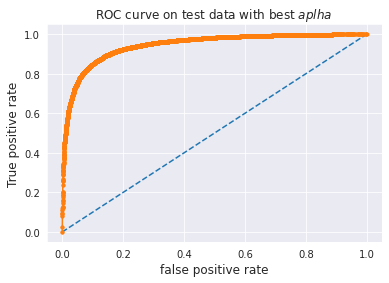

macro f1 score for data : 0.6648803679913108
micro f1 scoore for data: 0.8781532603522132
hamming loss for data: 0.12184673964778676
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.91      0.25      0.40      8646
           1       0.88      1.00      0.93     45980

    accuracy                           0.88     54626
   macro avg       0.90      0.62      0.66     54626
weighted avg       0.88      0.88      0.85     54626



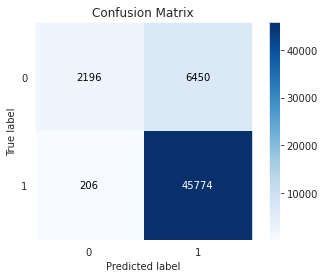

In [154]:
#testing the model
testing(bow_train, bow_test,y_train, y_test,optimal_alpha)

In [181]:
clf= MultinomialNB(alpha=optimal_alpha)
clf.fit(bow_train,y_train)
imp_df=impFeatures(count_vec,clf)
imp_df.head(10)

,Positive word,Positive importance,Negative word,Negative importance
0,not,-3.742774,not,-3.191045
1,great,-4.462724,like,-4.319836
2,good,-4.511766,product,-4.557148
3,like,-4.538338,taste,-4.574373
4,love,-4.811560,would,-4.619378
5,product,-4.874661,one,-4.842359
6,taste,-4.881829,good,-5.019567
7,one,-4.889562,flavor,-5.067688
8,flavor,-4.987896,no,-5.086001
9,coffee,-5.000973,coffee,-5.114900


##implementation of Tf-Idf

10000 ------> 0.6130564235405059
5000 ------> 0.6214197397126769
1000 ------> 0.6503387538954919
500 ------> 0.6656603326199247
100 ------> 0.7135305961009939
50 ------> 0.7447287824128963
10 ------> 0.8601849842848286
5 ------> 0.9143191013424807
1 ------> 0.9592747723057816
0.5 ------> 0.9613160810466317
0.1 ------> 0.9613566122154673
0.05 ------> 0.960331987192645
0.01 ------> 0.956505415635725
0.005 ------> 0.9543886935005952
0.001 ------> 0.9486637566891339
0.0005 ------> 0.9459431473743283
0.0001 ------> 0.9392984919668986
5e-05 ------> 0.9363688692247487
1e-05 ------> 0.9295704364645773
0.1  is the best value of alpha with an roc_auc score of  0.9613566122154673


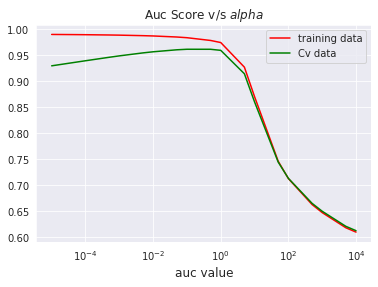

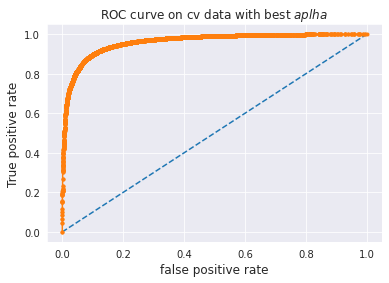

In [182]:
#training the model
optimal_alpha= NB(tfidf_train,tfidf_cv,y_train,y_cv)

AUC score on test data 0.9608931150304516


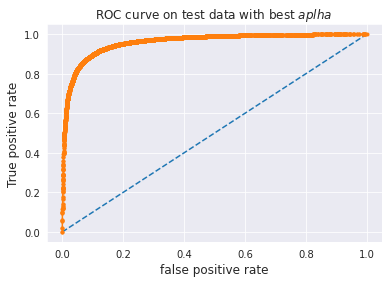

macro f1 score for data : 0.8285234206278088
micro f1 scoore for data: 0.9216856441987332
hamming loss for data: 0.07831435580126679
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.88      0.58      0.70      8646
           1       0.93      0.99      0.95     45980

    accuracy                           0.92     54626
   macro avg       0.90      0.78      0.83     54626
weighted avg       0.92      0.92      0.91     54626



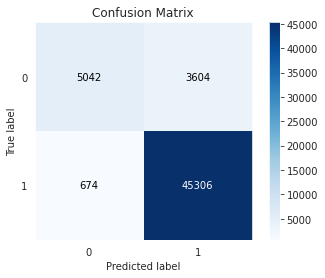

In [183]:
#testing the model
testing(tfidf_train, tfidf_test,y_train, y_test,optimal_alpha)

In [185]:
clf= MultinomialNB(alpha=optimal_alpha)
clf.fit(tfidf_train,y_train)
imp_df=impFeatures(tf_idf_vec,clf)
imp_df.head(10)

,Positive word,Positive importance,Negative word,Negative importance
0,not,-5.527642,not,-4.986352
1,great,-5.877305,like,-5.799395
2,good,-5.948560,product,-5.890993
3,like,-6.008957,taste,-5.935467
4,coffee,-6.090629,would,-5.941806
5,tea,-6.092233,one,-6.212404
6,love,-6.116936,coffee,-6.212923
7,product,-6.202917,no,-6.316757
8,taste,-6.235038,flavor,-6.362803
9,one,-6.245559,good,-6.457880


#Conclusion

In [189]:
from prettytable import PrettyTable
x= PrettyTable()
x.field_names= ["Vectorizer","Best hyper parameter","Test Auc Score"]
x.add_row (["BOW","0.1"," 94.49"])
x.add_row (["Tf-idf","0.1"," 96.08"])
print(x)

+------------+----------------------+----------------+
| Vectorizer | Best hyper parameter | Test Auc Score |
+------------+----------------------+----------------+
|    BOW     |         0.1          |      94.49     |
|   Tf-idf   |         0.1          |      96.08     |
+------------+----------------------+----------------+
